In [9]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import tsp, docplex
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.components.variational_forms import RY

from docplex.mp.model import Model

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
set_qiskit_aqua_logging(logging.ERROR)

distance
 [[ 0. 37. 23. 43.]
 [37.  0. 38. 14.]
 [23. 38.  0. 50.]
 [43. 14. 50.  0.]]


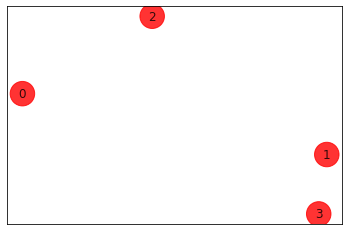

In [12]:
# Generating a graph of n nodes
n = 4

num_qubits = n ** 2
ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

order = (0, 1, 2, 3) Distance = 286.0
order = (0, 1, 3, 2) Distance = 277.0
order = (0, 2, 1, 3) Distance = 265.0
Best order from brute force = (0, 2, 1, 3) with total distance = 265.0


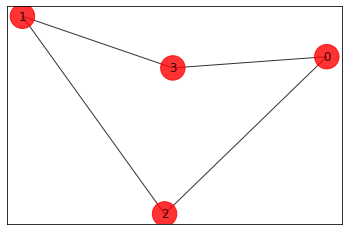

In [3]:
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order
  
best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

draw_tsp_solution(G, best_order, colors, pos)

In [13]:
qubitOp, offset = tsp.get_operator(ins)

energy: [-1600292.+0.j]
tsp objective: [118.+0.j]
feasible: True
solution: [2, 0, 3, 1]
solution objective: 118.0


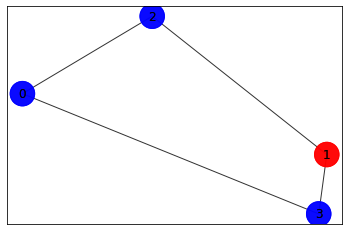

In [15]:
### Checking that the full Hamiltonian gives the right cost 

#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
from qiskit.aqua.algorithms import NumPyEigensolver
ee = NumPyEigensolver(qubitOp, k=1)
result = ee.run()

print('energy:', result['eigenvalues'])
print('tsp objective:', result['eigenvalues'] + offset)
x = sample_most_likely(result['eigenstates'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

colors = ['r' if tsp.get_tsp_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In [ ]:
from qiskit.circuit.library import TwoLocal, RealAmplitudes
seed = 10598

#spsa = SPSA(max_trials=100)
cobyla = COBYLA(maxiter=500)

#ry = TwoLocal(qubitOp.num_qubits, entanglement='linear', reps=5)
#ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
ry = RealAmplitudes(qubitOp.num_qubits, reps=3, entanglement='full')

vqe = VQE(qubitOp, ry, cobyla)
#vqe = VQE(qubitOp, ry, spsa)
vqe.random_seed = seed

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigenstate'])
print('energy:', result['eigenvalue'])
print('time:', result['optimizer_time'])
print('max-cut objective:', result['eigenvalue'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if tsp.get_tsp_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)